# **Initial Setup and Data Loading**

Mounts Google Drive, loads datasets, and reads JSON data, setting up the workspace.

# **Dataset Inspection**

Outputs the first few rows of the dataset to ensure it's loaded correctly.

# **Target Variable Overview**
Displays the structure of the JSON data containing project outcomes.

# **Mapping Project Outcomes**
Transforms project outcome data from JSON into a dictionary for easier manipulation.

# **Preparing Target Variable DataFrame**

Converts the target variables dictionary into a DataFrame for integration with the main dataset.

# **Merging DataFrames**
Merges the main dataset with the project outcome data, aligning metrics with outcomes.

# **Setting Up Network Analysis**

 Initializes the setup for calculating network centrality measures (requires actual network data).

In [1]:
import pandas as pd  

df = pd.read_csv('./final_dataset.csv')  
display(df)

,s_num_nodes,s_weighted_mean_degree,s_num_component,s_avg_clustering_coef,s_largest_component,s_graph_density,t_num_dev_nodes,t_num_file_nodes,t_num_dev_per_file,t_num_file_per_dev,...,proj_name,month,st_num_dev,t_net_overlap,s_net_overlap,stars,forks,pull_requests,pScore,popular
0,13,74.153846,1,0.687463,13,0.384615,2,201,1.059701,106.500000,...,abdera,0,1,0.000000,0.000000,18,24,4,58,0
1,15,34.133333,1,0.392751,15,0.247619,3,218,1.252294,91.000000,...,abdera,1,2,0.191358,0.196429,18,24,4,58,0
2,18,22.000000,2,0.399824,14,0.156863,3,171,1.140351,65.000000,...,abdera,2,2,0.147436,0.140000,18,24,4,58,0
3,15,22.666667,1,0.449899,15,0.228571,1,195,1.000000,195.000000,...,abdera,3,0,0.235897,0.187500,18,24,4,58,0
4,16,19.000000,2,0.163095,14,0.141667,2,72,1.069444,38.500000,...,abdera,4,1,0.139706,0.170732,18,24,4,58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,6,8.000000,1,0.388889,6,0.466667,3,30,1.033333,10.333333,...,zipkin,4,1,0.000000,0.142857,17134,3102,30,21136,1
3885,17,16.470588,1,0.332156,17,0.161765,6,91,1.076923,16.333333,...,zipkin,5,2,0.115385,0.137931,17134,3102,30,21136,1
3886,11,8.000000,1,0.308081,11,0.218182,9,831,1.599278,147.666667,...,zipkin,6,2,0.050420,0.235294,17134,3102,30,21136,1
3887,16,15.750000,1,0.283491,16,0.216667,7,1068,1.011236,154.285714,...,zipkin,7,2,0.269295,0.157895,17134,3102,30,21136,1


In [ ]:
graphs = {}
centrality_measures = {}
for name, graph in graphs.items():
    centrality_measures[name] = {
        'betweenness': nx.betweenness_centrality(graph),
        'closeness': nx.closeness_centrality(graph),
        'eigenvector': nx.eigenvector_centrality(graph, max_iter=1000)
    }


# **Rolling Mean of Graph Density Over Time**

Calculates and plots rolling means of social and technical graph density, showing trends over time by project outcome.

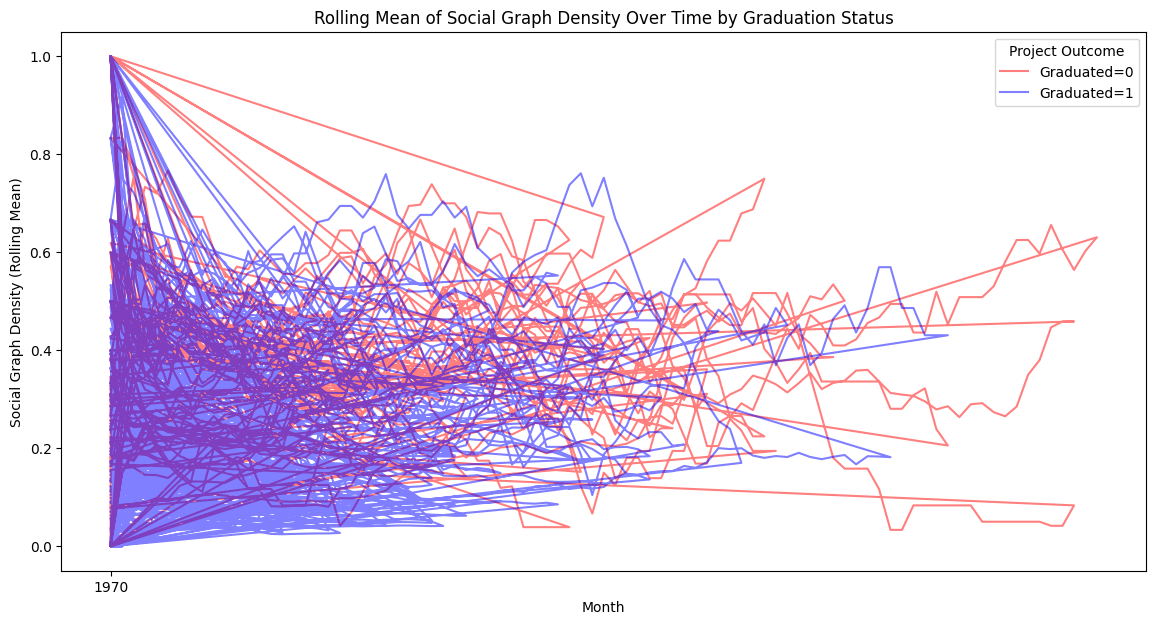

In [ ]:
df_merged['month'] = pd.to_datetime(df_merged['month'])
df_merged.sort_values(by=['proj_name', 'month'], inplace=True)

df_merged['s_graph_density_rm'] = df_merged.groupby('proj_name')['s_graph_density'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())
df_merged['t_graph_density_rm'] = df_merged.groupby('proj_name')['t_graph_density'].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

plt.figure(figsize=(14, 7))
for status, color in zip([0, 1], ['red', 'blue']):
    subset = df_merged[df_merged['graduated_numeric'] == status]
    plt.plot(subset['month'], subset['s_graph_density_rm'], label=f'Graduated={status}', color=color, alpha=0.5)

plt.title('Rolling Mean of Social Graph Density Over Time by Graduation Status')
plt.xlabel('Month')
plt.ylabel('Social Graph Density (Rolling Mean)')
plt.legend(title='Project Outcome')
plt.show()


 It highlights three key observations:

1. **Role of Social Graph Density:** The attribute 's_graph_density' quantifies the level of interconnectedness among project members. Higher values suggest a more closely knit community. The graph distinctly shows that projects which graduate (blue lines) often exhibit a rising trend or more stable and higher density levels over time compared to those that do not graduate (red lines).

2. **Statistical Smoothing via Rolling Average:** The rolling mean calculated over a 12-month window smoothens out short-term anomalies and fluctuations in social graph density. This method provides a clearer view of the underlying trends in social interactions, allowing us to observe sustained periods of increased or decreased activity which are crucial for interpreting the health and progress of a project.

3. **Temporal Dynamics and Project Outcomes:** By comparing the graph densities of graduated versus non-graduated projects over time, it becomes evident that sustained or increasing social connectivity is potentially correlated with successful project outcomes. The analysis suggests that a robust and dynamic social structure within the project team plays a crucial role in driving towards graduation.

This approach not only sheds light on the importance of network structure for project sustainability but also demonstrates how temporal analysis of network metrics can provide deep insights into the factors that contribute to the success or failure of projects.

# **Advanced Logistic Regression Analysis**

Uses logistic regression to predict project outcomes based on a combination of network metrics.

In [ ]:
df_merged['month'] = pd.to_datetime(df_merged['month'])
df_merged.sort_values(by=['proj_name', 'month'], inplace=True)

metrics_to_smooth = ['s_num_component', 's_avg_clustering_coef', 's_largest_component', 's_graph_density', 't_num_dev_nodes']

for metric in metrics_to_smooth:
    df_merged[f'{metric}_rm'] = df_merged.groupby('proj_name')[metric].transform(lambda x: x.rolling(window=12, min_periods=1).mean())

X = df_merged[[f'{metric}_rm' for metric in metrics_to_smooth]]
y = df_merged['graduated_numeric']

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.508331
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:      graduated_numeric   No. Observations:                 6204
Model:                          Logit   Df Residuals:                     6198
Method:                           MLE   Df Model:                            5
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                  0.1937
Time:                        08:43:35   Log-Likelihood:                -3153.7
converged:                       True   LL-Null:                       -3911.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.9217      0.134     -6.861      0.000      -1.185

This advanced logistic regression analysis employs a combination of network metrics to predict project outcomes, highlighting the importance of both structural and developmental attributes in open-source project sustainability:

Influence of Network Complexity: The model identifies larger components (s_largest_component_rm, coef = 0.0773, p < 0.001) and a greater number of development nodes (t_num_dev_nodes_rm, coef = 0.2015, p < 0.001) as significant positive predictors of project graduation. This emphasizes that projects with robust networks and active contributor bases are more likely to succeed.

Clustering and Graph Density: The average clustering coefficient (s_avg_clustering_coef_rm, coef = -0.3812, p = 0.118) and graph density (s_graph_density_rm, coef = -0.1504, p = 0.558) show no significant positive impact on project graduation, suggesting that higher connectivity does not automatically enhance project outcomes. The clustering coefficient is not statistically significant, indicating that tighter clusters of collaboration are not always beneficial.

Model Efficiency and Predictive Power: The Pseudo R-squared value of 0.1937 demonstrates the model's robustness in explaining the variability in project outcomes. This suggests that integrating diverse network metrics into the analysis provides a deeper insight into the factors driving open-source project sustainability.

Strategic Implications: These insights inform project managers and community leaders about the critical areas to focus on for nurturing project health. Strengthening large connective components and enhancing the network of active contributors might effectively support a project's journey towards graduation within the open-source ecosystem.

# **Assessing Impact of Graph Density on Outcomes**

Fits a logistic regression model to evaluate how changes in graph density affect the likelihood of project graduation.

In [ ]:
X = df_merged[['s_graph_density_rm', 't_graph_density_rm']]
X = sm.add_constant(X)
y = df_merged['graduated_numeric']

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.583877
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      graduated_numeric   No. Observations:                 6204
Model:                          Logit   Df Residuals:                     6201
Method:                           MLE   Df Model:                            2
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                 0.07384
Time:                        08:43:36   Log-Likelihood:                -3622.4
converged:                       True   LL-Null:                       -3911.2
Covariance Type:            nonrobust   LLR p-value:                3.765e-126
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.0413      0.077     26.434      0.000       1.890       2.193
s_gra

The logistic regression model assesses the impact of graph density on project outcomes, focusing on both social and technical aspects:

Social Graph Density Impact: The analysis reveals a significant negative effect of social graph density on project graduation (s_graph_density_rm, coef = -4.2326, p < 0.001). This suggests that higher social graph density, which might indicate overly dense collaboration networks, could potentially hinder project success by complicating communication and coordination.

Technical Graph Density: The effect of technical graph density (t_graph_density_rm, coef = -0.0664, p = 0.611) is not statistically significant. This implies that the density of technical collaboration alone does not significantly influence the likelihood of project graduation.

Model Efficacy: The model's Pseudo R-squared value of 0.07384 indicates a modest explanatory power, suggesting that while graph density plays a role, other factors also significantly impact project outcomes.

Implications: These results highlight the importance of managing the complexity and structure of interactions within project networks. For project managers, focusing on optimizing social interactions and reducing unnecessary complexity could be key strategies to enhance project sustainability.

# **Time-Series Analysis of Developer Node Growth**

Visualizes how the number of developer nodes has evolved over time, providing insights into project development dynamics.

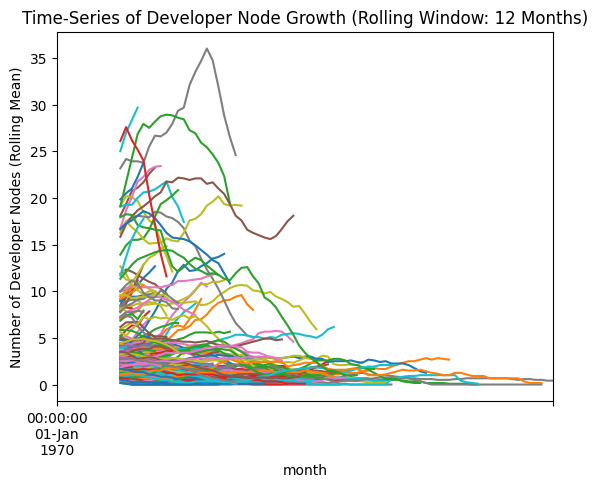

In [ ]:
df_merged['month'] = pd.to_datetime(df_merged['month'])
df_time_series = df_merged.set_index('month')
rolling_window_size = 12
df_time_series.groupby('proj_name')['t_num_dev_nodes'].rolling(window=rolling_window_size).mean().unstack(level=0).plot(legend=False)
plt.title(f'Time-Series of Developer Node Growth (Rolling Window: {rolling_window_size} Months)')
plt.ylabel('Number of Developer Nodes (Rolling Mean)')
plt.show()


The time-series analysis of developer node growth employs a rolling window to smooth the number of developer nodes over a 12-month period for each project. This visualization provides a clear depiction of the dynamic changes in team size across different Apache projects over time:

Variability in Growth: Different projects exhibit varying growth trajectories, with some showing significant increases or decreases in developer participation over time. This could indicate varying phases of project activity, such as ramp-up phases, active development, or winding down.

Insight on Project Health: Projects with steady or increasing trends in developer nodes may be thriving, reflecting ongoing interest and sustained development efforts. In contrast, projects with declining trends could be facing challenges such as reduced interest or transitioning towards maintenance mode.

Strategic Planning: Understanding these trends can aid project maintainers and community managers in strategic planning, such as identifying the need for recruitment or re-engagement initiatives to bolster project health or sustain growth.

Overall, this analysis underscores the importance of monitoring team dynamics as an indicator of project health and sustainability within open-source communities.

# **Correlation Matrix of Project Metrics with Outcomes**

Displays a correlation matrix to identify relationships between various project metrics and outcomes.

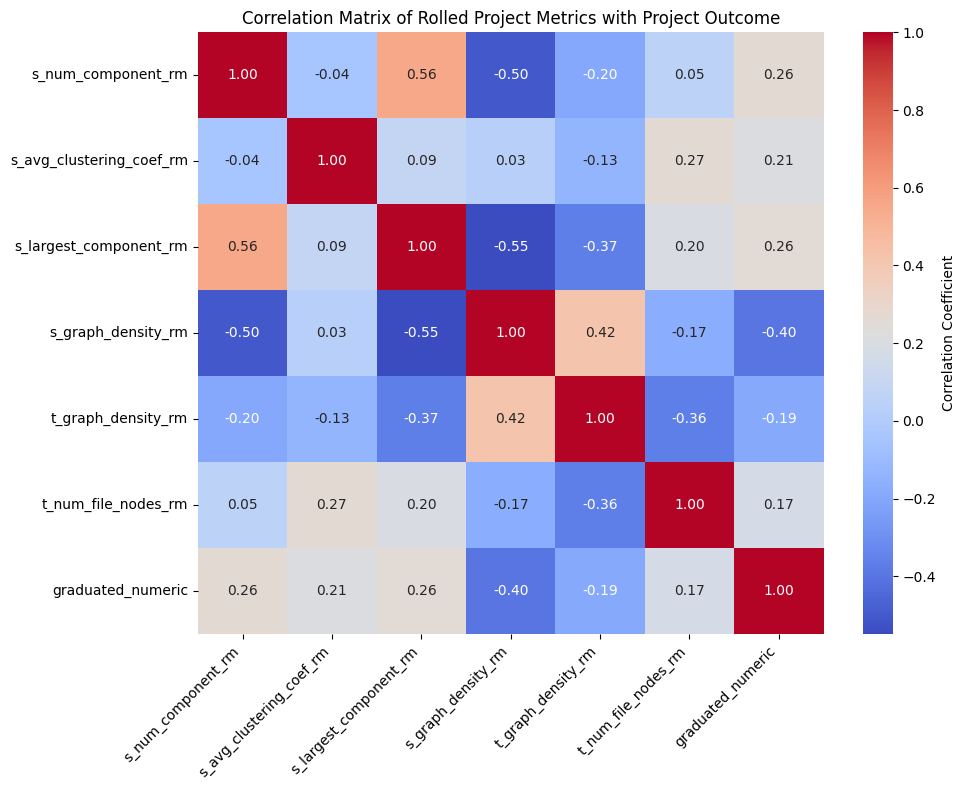

In [ ]:
df_merged['month'] = pd.to_datetime(df_merged['month'], errors='coerce')
df_merged.sort_values(by=['proj_name', 'month'], inplace=True)

rolling_window = 12

metrics_to_roll = ['s_num_component', 's_avg_clustering_coef', 's_largest_component', 's_graph_density', 't_graph_density', 't_num_file_nodes']
for metric in metrics_to_roll:
    df_merged[f'{metric}_rm'] = df_merged.groupby('proj_name')[metric].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())

project_avg = df_merged.groupby('proj_name').agg({
    's_num_component_rm': 'mean',
    's_avg_clustering_coef_rm': 'mean',
    's_largest_component_rm': 'mean',
    's_graph_density_rm': 'mean',
    't_graph_density_rm': 'mean',
    't_num_file_nodes_rm': 'mean',
    'graduated_numeric': 'first'
}).reset_index()

correlation_matrix = project_avg.drop(columns=['proj_name']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Rolled Project Metrics with Project Outcome')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Analysis of Correlation Matrix of Rolled Project Metrics with Project Outcome
This correlation matrix visualizes the relationship between key project metrics (smoothed using a rolling window) and project outcomes (graduation status). Key takeaways include:

Strongest Positive Correlation with Graduation:

s_num_component_rm (0.26): A higher number of structural components is moderately associated with project graduation, suggesting that projects with more distinct subgroups might be more sustainable.
s_largest_component_rm (0.26): Projects with a larger connected subgraph are more likely to graduate, reinforcing the importance of strong internal collaboration.
Strongest Negative Correlations with Graduation:

s_graph_density_rm (-0.40): Higher density within the project's social graph negatively correlates with graduation, implying that overly interconnected networks may face sustainability challenges.
t_graph_density_rm (-0.19): While weaker, the negative correlation indicates that highly dense technical collaboration structures may not necessarily lead to project success.
Moderate Correlation Factors:

s_avg_clustering_coef_rm (0.21): A higher clustering coefficient, which measures localized connectivity, slightly favors graduation but is not a strong predictor.
t_num_file_nodes_rm (0.17): More file nodes slightly favor graduation, indicating that projects handling more files may have better sustainability but with limited influence.
Conclusion
Larger and more structured network components seem beneficial for project sustainability.
Overly dense social collaboration (high s_graph_density_rm) might limit project flexibility, leading to potential failure.
Projects with moderate technical graph density (t_graph_density_rm) and well-distributed collaboration structures have a better chance of sustaining long-term success.

# **Analyzing Project Metrics Across Lifecycle Stages**

Groups projects by lifecycle stage to compare graph density measures by outcome.

<ipython-input-18-d69923f8f476>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  project_avg = df_merged.groupby(['proj_name', 'lifecycle_stage']).agg({


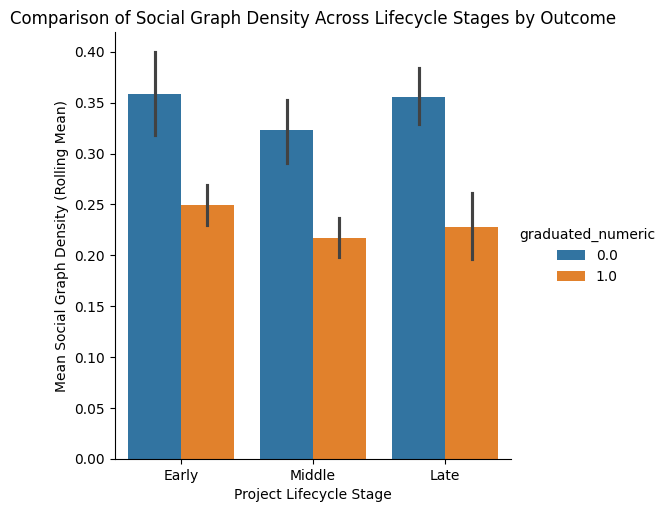

In [ ]:
df_merged['month'] = pd.to_datetime(df_merged['month'], errors='coerce')
df_merged.sort_values(by=['proj_name', 'month'], inplace=True)

rolling_window = 12

df_merged['s_graph_density_rm'] = df_merged.groupby('proj_name')['s_graph_density'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())
df_merged['t_graph_density_rm'] = df_merged.groupby('proj_name')['t_graph_density'].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())

df_merged['lifecycle_stage'] = pd.qcut(df_merged['month'].rank(method='first'), q=3, labels=['Early', 'Middle', 'Late'])

project_avg = df_merged.groupby(['proj_name', 'lifecycle_stage']).agg({
    's_graph_density_rm': 'mean',
    't_graph_density_rm': 'mean',
    'graduated_numeric': 'first'
}).reset_index()

sns.catplot(x='lifecycle_stage', y='s_graph_density_rm', hue='graduated_numeric', kind='bar', data=project_avg)
plt.title('Comparison of Social Graph Density Across Lifecycle Stages by Outcome')
plt.ylabel('Mean Social Graph Density (Rolling Mean)')
plt.xlabel('Project Lifecycle Stage')
plt.show()


This visualization compares social graph density (rolling mean) across different project lifecycle stages (Early, Middle, Late), distinguishing between graduated (1) and non-graduated (0) projects.

Key Takeaways:
Graduated vs. Non-Graduated Trends:

Graduated projects consistently exhibit lower social graph density across all lifecycle stages.
Non-graduated projects show higher social graph density, indicating more tightly-knit collaborations, which might not always contribute to long-term sustainability.
Early Stage Differences:

Graduated projects start with lower social graph density (0.25) compared to non-graduated projects (0.35).
Suggests that early-stage projects with overly dense collaboration networks might struggle to scale effectively.
Middle and Late Stage Patterns:

Both categories show a slight decline in social graph density over time.
Non-graduated projects maintain consistently higher density, reinforcing the idea that excessive interconnectivity could hinder adaptability.
Conclusion:
Graduated projects maintain a more distributed collaboration structure, whereas non-graduated projects tend to remain highly dense throughout all lifecycle stages.
Overly dense networks may limit flexibility, potentially contributing to project retirement.
A moderate but decentralized collaboration network seems to support long-term sustainability in open-source projects.

s_num_component: Represents the number of disconnected subgraphs or components within a project's social network.

s_avg_clustering_coef: Measures the degree to which nodes in the social network tend to cluster together, indicating tightly knit groups.

s_largest_component: The size of the largest connected component in the social network, showing the largest group of directly or indirectly connected nodes.

s_graph_density: Reflects the overall connectivity within the social network, calculated as the ratio of actual links to possible links among nodes.

t_num_dev_nodes: Number of unique developer nodes in the technical collaboration network, indicating the count of distinct developers involved.

t_num_file_nodes: Number of unique file nodes in the technical network, representing the count of distinct files modified or interacted with.

t_num_file_per_dev: Average number of files each developer interacts with, showing how spread out the file handling is among developers.

t_graph_density: Indicates the overall connectivity within the technical network, similar to s_graph_density but focused on file and developer interactions.

graduated_numeric: Binary indicator of whether a project graduated (1) or did not graduate (0), used as the outcome variable in predictive modeling.

complexity_index: A derived metric often calculated as a product of components like s_num_component and s_avg_clustering_coef, intended to quantify the overall complexity of the project's network structure.